# `friedrich` results

In [1]:
%matplotlib inline
# Import dev version of friedrich:
#import sys
#sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path)

    # Convert samples into spot measurements
    results = np.percentile(m.chains, [15.87, 50, 84.13], axis=0)

    spots = []
    for spot in np.split(results[:, 1:].T, (m.chains.shape[1]-1)/3):
        ampltiude, t0, sigma = map(lambda x: Measurement(*(x[1], 
                                                           x[2]-x[1], 
                                                           x[1]-x[0])), 
                                   spot)
        spots.append(Spot(ampltiude, t0, sigma)) 
    transits.append(Transit(spots))

load results


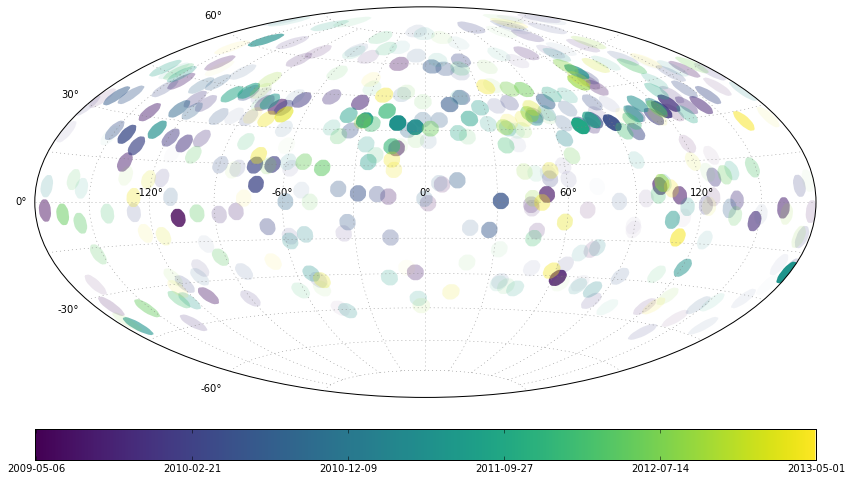

In [4]:
from friedrich.orientation import times_to_occulted_lat_lon
from friedrich.lightcurve import hat11_params_morris
from astroML.plotting import plot_tissot_ellipse

transit_params = hat11_params_morris()
projection = 'Hammer'

# Plot the built-in projections
fig = plt.figure(figsize=(14, 14))
ax = plt.subplot(211, projection=projection.lower())#, axisbg='black')
ax2 = plt.subplot(212)#, axisbg='black')

# plot latitude/longitude grid
ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3
                                            * np.linspace(-2, 2, 5)))
ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6
                                            * np.linspace(-5, 5, 11)))
ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6
                                            * np.linspace(-2, 2, 5)))
ax.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12
                                            * np.linspace(-5, 5, 11)))

ax.grid(True, which='minor', color='gray', ls=':')

# all_spot_times = np.array([spot.t0.value for spot in transit.spots 
#                            for transit in transits])
all_spot_times = np.array([spot.t0.value for transit in transits
                           for spot in transit.spots])
def tcolorscale(t):
    color = (t - all_spot_times.min())/(all_spot_times.max() - all_spot_times.min())
    return color

def sigma_prior(sigma):
    # Should less than 20 min, greater than 1
    if sigma*24*60 > 15 or sigma*24*60 < 2: 
        return 1e4
    else:
        return 1

radius = 2*transit_params.rp  # from s=r*theta

cmap = plt.cm.viridis
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        alpha = spot.amplitude.value*500/sigma_prior(spot.sigma.value)
        p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                            alpha = alpha if alpha < 1 else 1,
                            color=cmap(tcolorscale(spot.t0.value)))

from matplotlib.ticker import FuncFormatter
from astropy.time import Time
       
def plot_color_gradients(fig, ax):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack(10*[gradient])

    ax.imshow(gradient, cmap=plt.get_cmap('viridis'), aspect=1.0) 
    ax.set_yticks([])
    nticks = 6
    datespace = np.linspace(all_spot_times.min(), all_spot_times.max(), nticks)
    axspace = np.linspace(0, 256, nticks)
    xtickdates = [t.date() for t in Time(datespace, format='jd').datetime]
    ax.set_xticks(axspace)
    ax.set_xticklabels(xtickdates)

plot_color_gradients(fig, ax2)
fig.subplots_adjust(hspace=-0.55)

In [5]:
make_movie = False
if make_movie: 
    movie_times = np.linspace(Time('2009-05-06').jd, Time('2013-05-01').jd, 400)
    # Plot the built-in projections
    for i, current_time in enumerate(movie_times):
        fig = plt.figure(figsize=(14, 14))
        ax = plt.subplot(211, projection=projection.lower())#, axisbg='black')
        ax2 = plt.subplot(212)#, axisbg='black')

        # plot latitude/longitude grid
        ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3
                                                    * np.linspace(-2, 2, 5)))
        ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6
                                                    * np.linspace(-5, 5, 11)))
        ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6
                                                    * np.linspace(-2, 2, 5)))
        ax.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12
                                                    * np.linspace(-5, 5, 11)))

        ax.grid(True, which='minor', color='gray', ls=':')

        first_time = transits[0].spots[0].t0.value

        #current_time = transits[10].spots[0].t0.value
        for transit in transits:
            transit_t0_mean = np.mean([spot.t0.value for spot in transit.spots]) - current_time
            for spot in transit.spots:
                latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                                transit_params)

                if current_time > spot.t0.value:
                    fader = np.exp(-(current_time - spot.t0.value)/14) # fade by e in 7 days
                    alpha = spot.amplitude.value*500/sigma_prior(spot.sigma.value) * fader
                    if alpha > 1:
                        alpha = 1
                    elif alpha < 0:
                        alpha = 0
                    p = plot_tissot_ellipse(longitude, latitude, radius, ax=ax, linewidth=0,
                                        alpha = alpha if alpha < 1 else 1,
                                        color=cmap(tcolorscale(spot.t0.value)))
        plot_color_gradients(fig, ax2)
        fig.subplots_adjust(hspace=-0.55)
        ax.set_title("{0}".format(Time(current_time, format='jd').datetime.date()))
        plt.savefig('movie/{0:03d}.png'.format(i))
        plt.close()
    #plt.show()

In [6]:
all_lats = []
all_lons = []
all_amps = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
all_lats = np.array(all_lats)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)

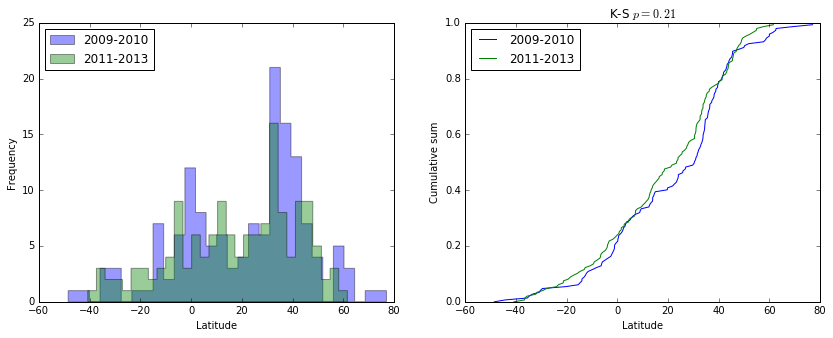

In [7]:
strong_lats = all_lats[np.median(all_amps) < all_amps]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lats = strong_lats[:int(0.5*len(strong_lats))]
second_half_strong_lats = strong_lats[-len(first_half_strong_lats):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lats), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lats), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lats)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lats)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lats.ravel(), second_half_strong_lats.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Latitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Latitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

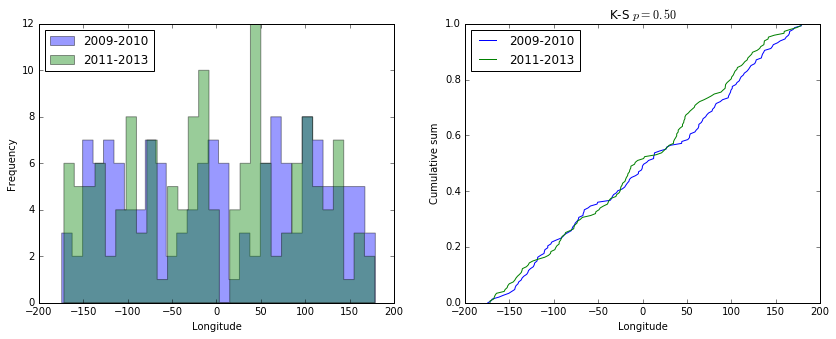

In [8]:
strong_lons = all_lons[np.median(all_amps) < all_amps]
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
first_half_strong_lons = strong_lons[:int(0.5*len(strong_lons))]
second_half_strong_lons = strong_lons[-len(first_half_strong_lons):]

nbins = 30
ax[0].hist(np.degrees(first_half_strong_lons), nbins, histtype='stepfilled',
           facecolor='b', alpha=0.4, label='2009-2010')
ax[0].hist(np.degrees(second_half_strong_lons), nbins, histtype='stepfilled', 
           facecolor='g', alpha=0.4, label='2011-2013')

def cumdist(Z):
    N = len(Z)
    return np.sort(Z.ravel()), np.arange(N)/N

ax[1].plot(*cumdist(np.degrees(first_half_strong_lons)), label='2009-2010')
ax[1].plot(*cumdist(np.degrees(second_half_strong_lons)), label='2011-2013')

from scipy.stats import ks_2samp
ks = ks_2samp(first_half_strong_lons.ravel(), second_half_strong_lons.ravel())

ax[0].legend(loc='upper left')
ax[0].set(xlabel='Longitude', ylabel='Frequency')
ax[1].legend(loc='upper left')
ax[1].set(xlabel='Longitude', ylabel='Cumulative sum', 
          title="K-S $p={0:.2f}$".format(ks.pvalue))
plt.show()

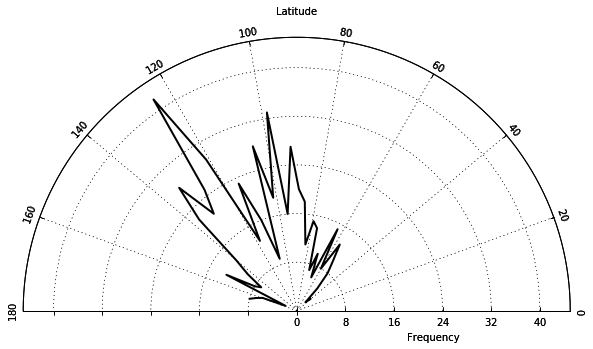

In [9]:
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist.grid_finder import (FixedLocator, MaxNLocator,
                                                 DictFormatter)
def setup_axes3(fig, rect):
    """
    Sometimes, things like axis_direction need to be adjusted.
    """

    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(0, 0)
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)
    tr = tr_rotate + tr_scale + PolarAxes.PolarTransform()
    grid_locator2 = MaxNLocator(6)

    ra0, ra1 = 0, 180
    cz0, cz1 = 0, 45
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(ra0, ra1, cz0, cz1),
        grid_locator1=None,
        grid_locator2=grid_locator2,
        tick_formatter1=None,
        tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    # adjust axis
    ax1.axis["left"].set_axis_direction("bottom")
    #ax1.axis["right"].set_axis_direction("top")

    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_axis_direction("bottom")
    ax1.axis["top"].toggle(ticklabels=True, label=True)
    ax1.axis["top"].major_ticklabels.set_axis_direction("top")
    ax1.axis["top"].label.set_axis_direction("top")

    ax1.axis["left"].label.set_text(r"Frequency")
    ax1.axis["top"].label.set_text(r"Latitude")

    # create a parasite axes whose transData in RA, cz
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  
    ax1.grid()
    return ax1, aux_ax

lat_freq, lat_bins = np.histogram(all_lats, 40)
lat_bin_centers = 0.5*(lat_bins[1:] + lat_bins[:-1])

fig = plt.figure(figsize=(10,10))
_, ax = setup_axes3(fig, 111)
ax.plot(np.degrees(lat_bin_centers + np.pi/2), lat_freq, lw=2, color='k')